<a href="https://colab.research.google.com/github/ZahraAlharz/Oxford-AI-Summer-School/blob/main/Classification_CNN_HW_CV_Oxford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building and Optimizing a CNN

In this assignment, you will design, implement, and optimize a Convolutional Neural Network (CNN) using PyTorch to classify images from the CIFAR-10 dataset. This will involve advanced preprocessing techniques, sophisticated model architectures, hyperparameter tuning, ensemble learning, adversarial training, and AutoML.

##Dataset:
You will use the CIFAR-10 dataset, consisting of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

##Tasks:
Load and Preprocess the Data

1. Data Augmentation
2. Design a Complex CNN Architecture with Inception Bottlenecks
3. Implement and Compare Different Optimizers
4. Use Learning Rate Scheduling
5. Apply Regularization Techniques
6. Perform Extensive Hyperparameter Tuning
7. Ensemble Learning
8. Adversarial Training
9. Automated Machine Learning (AutoML)
10. Evaluate the Model with Advanced Metrics
11. Visualize the Results


In [ ]:
from IPython.display import clear_output

In [ ]:
%pip install torch torchvision
%pip install matplotlib


clear_output()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, resize
from torch.optim import Adam, AdamW, Adamax
#from torchsummary import summary


In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

Augmentation & Transformation

In [ ]:
# Load and preprocess data
transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 50000
Number of test examples: 10000


Inception Model

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()

        # Branch 1: 1x1 conv
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        # Branch 2: 1x1 conv followed by 3x3 conv
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Branch 3: 1x1 conv followed by 5x5 conv
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

        # Branch 4: 3x3 max pooling followed by 1x1 conv
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        # Concatenate along the channel dimension
        outputs = torch.cat([branch1, branch2, branch3, branch4], dim=1)
        return outputs

In [ ]:
class ComplexCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ComplexCNN, self).__init__()

        self.initial_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.inception1 = InceptionBlock(64, 32)
        self.inception2 = InceptionBlock(128, 64)
        self.inception3 = InceptionBlock(256, 128)

        self.fc = nn.Sequential(
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        x = self.inception1(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        x = self.inception2(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        x = self.inception3(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ComplexCNN().to(device)

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
            Conv2d-2             [-1, 32, 8, 8]           2,080
              ReLU-3             [-1, 32, 8, 8]               0
            Conv2d-4             [-1, 32, 8, 8]           2,080
              ReLU-5             [-1, 32, 8, 8]               0
            Conv2d-6             [-1, 32, 8, 8]           9,248
              ReLU-7             [-1, 32, 8, 8]               0
            Conv2d-8             [-1, 32, 8, 8]           2,080
              ReLU-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 32, 8, 8]          25,632
             ReLU-11             [-1, 32, 8, 8]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 32, 8, 8]           2,080
             ReLU-14             [-1, 3

In [ ]:
def train_and_evaluate(optimizer_name, optimizer_class):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ComplexCNN().to(device)
    num_epochs = 20
    lr = 1e-3

    train_losses = []
    val_losses = []

    optimizer = optimizer_class(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.to(device)
    print(f'Using optimizer {optimizer_name} on device {device}')

    for epoch_no in range(num_epochs):
        model.train()
        epoch_weighted_loss = 0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            batch_y_probs = model(batch_X)
            loss = criterion(batch_y_probs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_weighted_loss += (len(batch_y) * loss.item())

        epoch_loss = epoch_weighted_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        correctly_labelled = 0

        with torch.no_grad():
            val_epoch_weighted_loss = 0

            for val_batch_X, val_batch_y in test_loader:
                val_batch_X = val_batch_X.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_probs = model(val_batch_X)
                loss = criterion(val_batch_y_probs, val_batch_y)
                val_epoch_weighted_loss += (len(val_batch_y) * loss.item())

                val_batch_y_pred = val_batch_y_probs.argmax(dim=1)
                correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

        val_epoch_loss = val_epoch_weighted_loss / len(test_loader.dataset)
        val_losses.append(val_epoch_loss)

        print(f'Epoch: {epoch_no}, train_loss={epoch_loss:.4f}, val_loss={val_epoch_loss:.4f}, correctly_labelled={correctly_labelled}/{len(test_loader.dataset)} ({correctly_labelled/len(test_loader.dataset)*100:.2f}% accuracy)')

    print(f'Training complete with optimizer {optimizer_name}.')
    return train_losses, val_losses

Implement and Compare Different Optimizers

Using optimizer Adam on device cuda
Epoch: 0, train_loss=2.1373, val_loss=2.1059, correctly_labelled=3510/10000 (35.10% accuracy)
Epoch: 1, train_loss=2.0467, val_loss=2.0651, correctly_labelled=3942/10000 (39.42% accuracy)
Epoch: 2, train_loss=2.0007, val_loss=2.0766, correctly_labelled=3809/10000 (38.09% accuracy)
Epoch: 3, train_loss=1.9689, val_loss=2.0914, correctly_labelled=3673/10000 (36.73% accuracy)
Epoch: 4, train_loss=1.9387, val_loss=2.0070, correctly_labelled=4522/10000 (45.22% accuracy)
Epoch: 5, train_loss=1.9267, val_loss=1.9839, correctly_labelled=4752/10000 (47.52% accuracy)
Epoch: 6, train_loss=1.9135, val_loss=2.0266, correctly_labelled=4331/10000 (43.31% accuracy)
Epoch: 7, train_loss=1.9113, val_loss=1.9986, correctly_labelled=4605/10000 (46.05% accuracy)
Epoch: 8, train_loss=1.9019, val_loss=2.0486, correctly_labelled=4109/10000 (41.09% accuracy)
Epoch: 9, train_loss=1.9107, val_loss=2.0476, correctly_labelled=4121/10000 (41.21% accuracy)
Epoch: 10, train_loss=1.

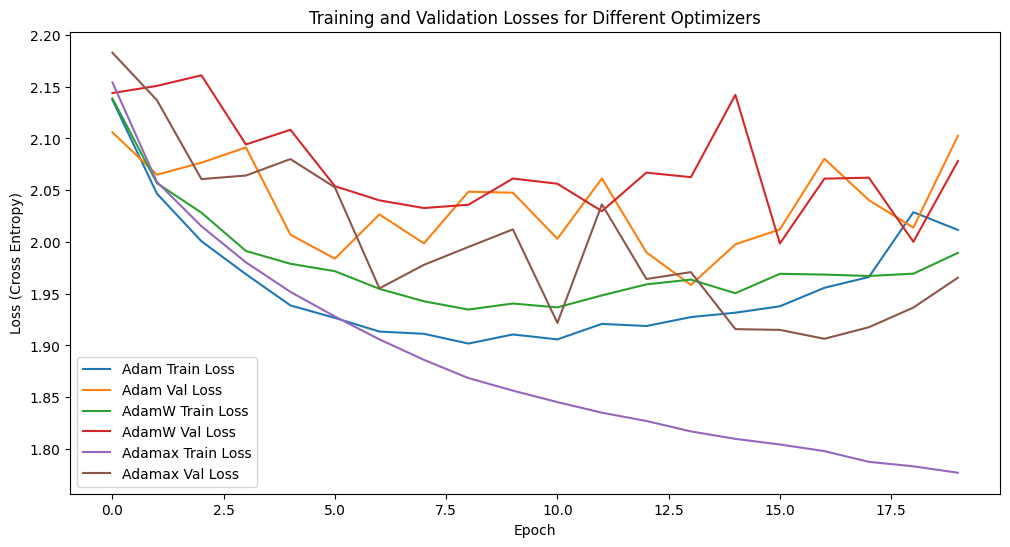

In [ ]:
# Define optimizers to test
optimizers_to_test = {
    "Adam": Adam,
    "AdamW": AdamW,
    "Adamax": Adamax,
}

# Store results for plotting
results = {}

for optimizer_name, optimizer_class in optimizers_to_test.items():
    train_losses, val_losses = train_and_evaluate(optimizer_name, optimizer_class)
    results[optimizer_name] = {"train_losses": train_losses, "val_losses": val_losses}

# Plot the results
plt.figure(figsize=(12, 6))

for optimizer_name, losses in results.items():
    plt.plot(losses["train_losses"], label=f'{optimizer_name} Train Loss')
    plt.plot(losses["val_losses"], label=f'{optimizer_name} Val Loss')

plt.title('Training and Validation Losses for Different Optimizers')
plt.ylabel('Loss (Cross Entropy)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Hyperparameter Tuning with Bayesian Optimization using Optuna

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 14.5 MB/s eta 0:00:00


In [ ]:
import optuna
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm, dropout_prob):
        super(InceptionBlock, self).__init__()

        self.batch_norm = batch_norm
        self.dropout_prob = dropout_prob

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        if batch_norm:
            self.batch_norm_layer = nn.BatchNorm2d(out_channels * 4)

        if dropout_prob > 0:
            self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = torch.cat([branch1, branch2, branch3, branch4], dim=1)

        if self.batch_norm:
            outputs = self.batch_norm_layer(outputs)

        if self.dropout_prob > 0:
            outputs = self.dropout(outputs)

        return outputs

In [ ]:
class ComplexCNN(nn.Module):
    def __init__(self, num_classes=10, num_inception_blocks=3, inception_out_channels=32, batch_norm=False, dropout_prob=0):
        super(ComplexCNN, self).__init__()

        self.initial_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.inception_blocks = nn.ModuleList()
        in_channels = 64

        for i in range(num_inception_blocks):
            self.inception_blocks.append(InceptionBlock(in_channels, inception_out_channels, batch_norm, dropout_prob))
            in_channels = inception_out_channels * 4

        self.fc = nn.Sequential(
            nn.Linear(in_channels, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        for block in self.inception_blocks:
            x = block(x)
            x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
def train_and_evaluate(trial):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_classes = 10

    # Hyperparameters
    num_inception_blocks = trial.suggest_int('num_inception_blocks', 2, 5)
    inception_out_channels = trial.suggest_int('inception_out_channels', 16, 64, step=16)
    batch_norm = trial.suggest_categorical('batch_norm', [True, False])
    dropout_prob = trial.suggest_float('dropout_prob', 0, 0.5, step=0.1)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)

    model = ComplexCNN(num_classes=num_classes, num_inception_blocks=num_inception_blocks,
                       inception_out_channels=inception_out_channels, batch_norm=batch_norm, dropout_prob=dropout_prob).to(device)

    optimizer = Adamax(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    num_epochs = 30

    for epoch_no in range(num_epochs):
        model.train()
        epoch_weighted_loss = 0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            batch_y_probs = model(batch_X)
            loss = criterion(batch_y_probs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_weighted_loss += (len(batch_y) * loss.item())

        epoch_loss = epoch_weighted_loss / len(train_loader.dataset)

        model.eval()
        correctly_labelled = 0

        with torch.no_grad():
            val_epoch_weighted_loss = 0

            for val_batch_X, val_batch_y in test_loader:
                val_batch_X = val_batch_X.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_probs = model(val_batch_X)
                loss = criterion(val_batch_y_probs, val_batch_y)
                val_epoch_weighted_loss += (len(val_batch_y) * loss.item())

                val_batch_y_pred = val_batch_y_probs.argmax(dim=1)
                correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

        val_epoch_loss = val_epoch_weighted_loss / len(test_loader.dataset)

        trial.report(val_epoch_loss, epoch_no)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_epoch_loss

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(train_and_evaluate, n_trials=20)

# Print best trial
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Plot optimization history
optuna.visualization.plot_optimization_history(study)

# Plot parameter importance
optuna.visualization.plot_param_importances(study)

[I 2024-07-22 10:04:19,030] A new study created in memory with name: no-name-6afc2abc-795c-4653-ad35-bc6e1d7123e4
[I 2024-07-22 10:10:27,602] Trial 0 finished with value: 1.8380281211853027 and parameters: {'num_inception_blocks': 3, 'inception_out_channels': 32, 'batch_norm': True, 'dropout_prob': 0.2, 'lr': 0.005275038961521902, 'weight_decay': 0.00010231825222234272}. Best is trial 0 with value: 1.8380281211853027.
[I 2024-07-22 10:16:30,969] Trial 1 finished with value: 1.8959510540008544 and parameters: {'num_inception_blocks': 4, 'inception_out_channels': 48, 'batch_norm': True, 'dropout_prob': 0.1, 'lr': 0.0013340439892968504, 'weight_decay': 0.0015447882479244428}. Best is trial 0 with value: 1.8380281211853027.
[I 2024-07-22 10:22:34,670] Trial 2 finished with value: 2.0784349433898925 and parameters: {'num_inception_blocks': 3, 'inception_out_channels': 32, 'batch_norm': True, 'dropout_prob': 0.0, 'lr': 0.00975750445470038, 'weight_decay': 0.0017290843406788609}. Best is tria

Best trial:
  Value: 1.8281027172088624
  Params: 
    num_inception_blocks: 3
    inception_out_channels: 48
    batch_norm: True
    dropout_prob: 0.2
    lr: 0.0028176173143198494
    weight_decay: 0.0003867559701533587


Model with best hyperparameters (CNNInception1)

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm, dropout_prob):
        super(InceptionBlock, self).__init__()

        self.batch_norm = batch_norm
        self.dropout_prob = dropout_prob

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        if batch_norm:
            self.batch_norm_layer = nn.BatchNorm2d(out_channels * 4)

        if dropout_prob > 0:
            self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = torch.cat([branch1, branch2, branch3, branch4], dim=1)

        if self.batch_norm:
            outputs = self.batch_norm_layer(outputs)

        if self.dropout_prob > 0:
            outputs = self.dropout(outputs)

        return outputs

class ComplexCNN(nn.Module):
    def __init__(self, num_classes=10, num_inception_blocks=5, inception_out_channels=64, batch_norm=True, dropout_prob=0.1):
        super(ComplexCNN, self).__init__()

        self.initial_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.inception_blocks = nn.ModuleList()
        in_channels = 64

        for i in range(num_inception_blocks):
            self.inception_blocks.append(InceptionBlock(in_channels, inception_out_channels, batch_norm, dropout_prob))
            in_channels = inception_out_channels * 4

        self.fc = nn.Sequential(
            nn.Linear(in_channels, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        for block in self.inception_blocks:
            x = block(x)
            x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
# Best hyperparameters obtained from Optuna
best_params = {
    'num_inception_blocks': 3,
    'inception_out_channels': 48,
    'batch_norm': True,
    'dropout_prob': 0.2,
    'lr': 0.0028176173143198494,
    'weight_decay': 0.0003867559701533587
}

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ComplexCNN(num_classes=10, num_inception_blocks=best_params['num_inception_blocks'],
                   inception_out_channels=best_params['inception_out_channels'],
                   batch_norm=best_params['batch_norm'], dropout_prob=best_params['dropout_prob']).to(device)
num_epochs = 30
lr = best_params['lr']
weight_decay = best_params['weight_decay']

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = Adamax(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model.to(device)

print(f'Using device {device}')

for epoch_no in range(num_epochs):
    model.train()
    epoch_weighted_loss = 0
    correctly_train_labelled = 0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        batch_y_probs = model(batch_X)
        loss = criterion(batch_y_probs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_weighted_loss += (len(batch_y) * loss.item())

        train_batch_y_pred = batch_y_probs.argmax(dim=1)
        correctly_train_labelled += ( train_batch_y_pred == batch_y).sum().item()

    epoch_loss = epoch_weighted_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_acc.append((correctly_train_labelled/len(train_loader.dataset))*100)

    model.eval()
    correctly_labelled = 0

    with torch.no_grad():
        val_epoch_weighted_loss = 0

        for val_batch_X, val_batch_y in test_loader:
            val_batch_X = val_batch_X.to(device)
            val_batch_y = val_batch_y.to(device)

            val_batch_y_probs = model(val_batch_X)
            loss = criterion(val_batch_y_probs, val_batch_y)
            val_epoch_weighted_loss += (len(val_batch_y) * loss.item())

            val_batch_y_pred = val_batch_y_probs.argmax(dim=1)
            correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

    val_epoch_loss = val_epoch_weighted_loss / len(test_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_acc.append(correctly_labelled/len(test_loader.dataset)*100)

    print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. train Accuracy: {(correctly_train_labelled/len(train_loader.dataset))*100}% validation Accuracy: {correctly_labelled/len(test_loader.dataset)*100}%')

Using device cuda
Epoch: 0, train_loss=2.080903268432617, val_loss=2.1199636207580568. train Accuracy: 38.542% validation Accuracy: 33.17%
Epoch: 1, train_loss=1.9686710745239258, val_loss=2.0437563705444335. train Accuracy: 49.714000000000006% validation Accuracy: 41.14%
Epoch: 2, train_loss=1.9247355123901366, val_loss=2.0503410495758057. train Accuracy: 54.2% validation Accuracy: 40.510000000000005%
Epoch: 3, train_loss=1.8968121801757813, val_loss=1.968480110168457. train Accuracy: 57.196000000000005% validation Accuracy: 49.34%
Epoch: 4, train_loss=1.8833216118621827, val_loss=1.978830860900879. train Accuracy: 58.802% validation Accuracy: 49.02%
Epoch: 5, train_loss=1.8695803638458253, val_loss=1.9961432628631592. train Accuracy: 60.629999999999995% validation Accuracy: 47.349999999999994%
Epoch: 6, train_loss=1.8635638666152954, val_loss=1.9620338687896728. train Accuracy: 61.870000000000005% validation Accuracy: 51.31%
Epoch: 7, train_loss=1.8567458726501465, val_loss=1.9562022

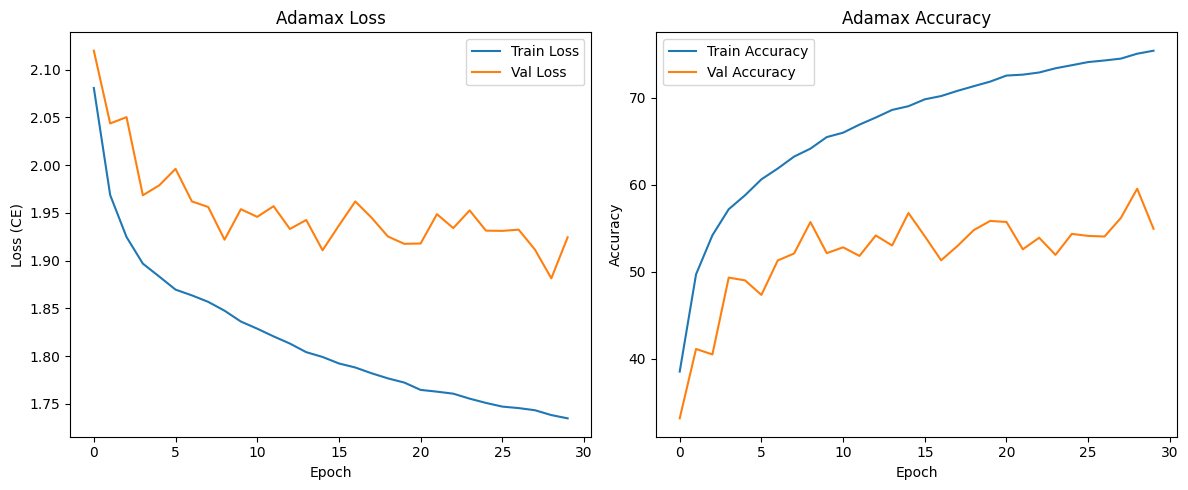

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Adamax Loss')
plt.ylabel('Loss (CE)')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Adamax Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'CNNInception1.pth')

Using Learning Rate Scheduler (CNNInception2 model)

In [ ]:
# Load and preprocess data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2) # The DataLoader split the datset into batches to feed them into NN
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ComplexCNN(num_classes=10, num_inception_blocks=best_params['num_inception_blocks'],
                   inception_out_channels=best_params['inception_out_channels'],
                   batch_norm=best_params['batch_norm'], dropout_prob=best_params['dropout_prob']).to(device)
#model.load_state_dict(torch.load('CNNInception2.pth'))

num_epochs = 20
lr = best_params['lr']
weight_decay = best_params['weight_decay']

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

optimizer = Adamax(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # StepLR scheduler
criterion = nn.CrossEntropyLoss()

model.to(device)

print(f'Using device {device}')

for epoch_no in range(num_epochs):
    model.train()
    epoch_weighted_loss = 0
    correct_train = 0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        batch_y_probs = model(batch_X)
        loss = criterion(batch_y_probs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_weighted_loss += (len(batch_y) * loss.item())

        batch_y_pred = batch_y_probs.argmax(dim=1)
        correct_train += (batch_y_pred == batch_y).sum().item()

    epoch_loss = epoch_weighted_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    train_accuracy = correct_train / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_val = 0
    val_epoch_weighted_loss = 0

    with torch.no_grad():
        for val_batch_X, val_batch_y in test_loader:
            val_batch_X = val_batch_X.to(device)
            val_batch_y = val_batch_y.to(device)

            val_batch_y_probs = model(val_batch_X)
            loss = criterion(val_batch_y_probs, val_batch_y)
            val_epoch_weighted_loss += (len(val_batch_y) * loss.item())

            val_batch_y_pred = val_batch_y_probs.argmax(dim=1)
            correct_val += (val_batch_y_pred == val_batch_y).sum().item()

    val_epoch_loss = val_epoch_weighted_loss / len(test_loader.dataset)
    val_losses.append(val_epoch_loss)

    val_accuracy = correct_val / len(test_loader.dataset)
    val_accuracies.append(val_accuracy)

    scheduler.step()  # Update the learning rate

    print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. train_accuracy={train_accuracy*100}%, val_accuracy={val_accuracy*100}%')


Using device cuda
Epoch: 0, train_loss=2.052481569366455, val_loss=1.9814538021087647. train_accuracy=41.738%, val_accuracy=48.730000000000004%
Epoch: 1, train_loss=1.9559837090301513, val_loss=1.9525779811859132. train_accuracy=51.275999999999996%, val_accuracy=50.96000000000001%
Epoch: 2, train_loss=1.9177028908920288, val_loss=1.8984252281188965. train_accuracy=54.94%, val_accuracy=56.830000000000005%
Epoch: 3, train_loss=1.8985954413604735, val_loss=1.8908348640441894. train_accuracy=56.846%, val_accuracy=57.36%
Epoch: 4, train_loss=1.8820826529693604, val_loss=1.8754970262527466. train_accuracy=58.81999999999999%, val_accuracy=59.4%
Epoch: 5, train_loss=1.8670902771377564, val_loss=1.8580838331222533. train_accuracy=60.587999999999994%, val_accuracy=61.61%
Epoch: 6, train_loss=1.85623045753479, val_loss=1.8542083185195923. train_accuracy=61.998%, val_accuracy=62.36000000000001%
Epoch: 7, train_loss=1.851087354736328, val_loss=1.8562235805511476. train_accuracy=63.105999999999995%,

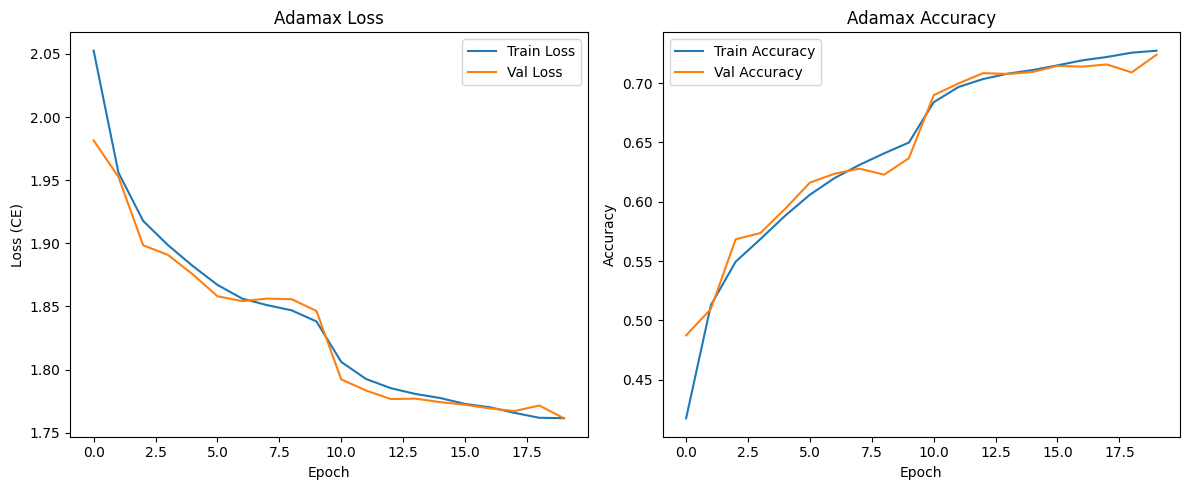

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Adamax Loss')
plt.ylabel('Loss (CE)')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Adamax Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'CNNInception2.pth')

Ensemble Learning

In [ ]:
# Train and save custom models
num_custom_models = 3
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

for i in range(num_custom_models):
    print(f"Training Custom Model {i+1}")
    model = ComplexCNN(num_classes=10,
                        num_inception_blocks=best_params['num_inception_blocks'],
                        inception_out_channels=best_params['inception_out_channels'],
                        batch_norm=best_params['batch_norm'],
                        dropout_prob=best_params['dropout_prob'])

    # Move the model to the device
    model.to(device) # Add this line

    # Train the model
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_pretrained_model(
        model, train_loader, test_loader,
        num_epochs=30,
        lr=best_params['lr'],
        weight_decay=best_params['weight_decay']
    )

    # Save the model
    torch.save(model.state_dict(), f'custom_model_{i+1}.pth')

    # Store losses and accuracies
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

Training Custom Model 1
Epoch: 0, train_loss=2.053041250152588, val_loss=1.9793436748504638. train_accuracy=41.711999999999996%, val_accuracy=48.96%
Epoch: 1, train_loss=1.9566593598175048, val_loss=1.9448656866073608. train_accuracy=51.086%, val_accuracy=52.300000000000004%
Epoch: 2, train_loss=1.9208240814590454, val_loss=1.9439227291107177. train_accuracy=54.69199999999999%, val_accuracy=51.790000000000006%
Epoch: 3, train_loss=1.8983067630767823, val_loss=1.8843341703414918. train_accuracy=56.99999999999999%, val_accuracy=58.19%
Epoch: 4, train_loss=1.8815555163574218, val_loss=1.8881526124954224. train_accuracy=58.940000000000005%, val_accuracy=58.02%
Epoch: 5, train_loss=1.8682381869888305, val_loss=1.8538874124526978. train_accuracy=60.388%, val_accuracy=62.03999999999999%
Epoch: 6, train_loss=1.8593747723770142, val_loss=1.8554625452041626. train_accuracy=61.824%, val_accuracy=62.050000000000004%
Epoch: 7, train_loss=1.8530299981307983, val_loss=1.847442928314209. train_accurac

In [ ]:
import torchvision.models as models

# Modify the models to match the number of classes in your dataset
resnet = models.resnet18(pretrained=True)
vgg = models.vgg16(pretrained=True)

# Modify the final layer of ResNet
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)  # CIFAR-10 has 10 classes

# Modify the final layer of VGG
num_ftrs = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_ftrs, 10)  # CIFAR-10 has 10 classes

# Move the models to the appropriate device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet = resnet.to(device)
vgg = vgg.to(device)

In [ ]:
# Define the training function for pre-trained models
def train_pretrained_model(model, train_loader, test_loader, num_epochs=15, lr=0.001, weight_decay=0.0):
    optimizer = Adamax(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch_no in range(num_epochs):
        model.train()
        epoch_weighted_loss = 0
        correct_train = 0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            batch_y_probs = model(batch_X)
            loss = criterion(batch_y_probs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_weighted_loss += (len(batch_y) * loss.item())

            batch_y_pred = batch_y_probs.argmax(dim=1)
            correct_train += (batch_y_pred == batch_y).sum().item()

        epoch_loss = epoch_weighted_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        train_accuracy = correct_train / len(train_loader.dataset)
        train_accuracies.append(train_accuracy)

        model.eval()
        correct_val = 0
        val_epoch_weighted_loss = 0

        with torch.no_grad():
            for val_batch_X, val_batch_y in test_loader:
                val_batch_X = val_batch_X.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_probs = model(val_batch_X)
                loss = criterion(val_batch_y_probs, val_batch_y)
                val_epoch_weighted_loss += (len(val_batch_y) * loss.item())

                val_batch_y_pred = val_batch_y_probs.argmax(dim=1)
                correct_val += (val_batch_y_pred == val_batch_y).sum().item()

        val_epoch_loss = val_epoch_weighted_loss / len(test_loader.dataset)
        val_losses.append(val_epoch_loss)

        val_accuracy = correct_val / len(test_loader.dataset)
        val_accuracies.append(val_accuracy)

        scheduler.step()

        print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. train_accuracy={train_accuracy*100}%, val_accuracy={val_accuracy*100}%')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Train and save ResNet
resnet, resnet_train_losses, resnet_val_losses, resnet_train_accuracies, resnet_val_accuracies = train_pretrained_model(resnet, train_loader, test_loader)
torch.save(resnet.state_dict(), 'resnet18_finetuned.pth')

Epoch: 0, train_loss=0.9883688737678528, val_loss=0.6911166278839111. train_accuracy=65.732%, val_accuracy=75.99000000000001%
Epoch: 1, train_loss=0.6935017267417908, val_loss=0.6160471192359924. train_accuracy=76.238%, val_accuracy=78.67%
Epoch: 2, train_loss=0.5943904140853882, val_loss=0.5555018387794495. train_accuracy=79.294%, val_accuracy=81.42%
Epoch: 3, train_loss=0.5373637741470337, val_loss=0.5265299598693848. train_accuracy=81.474%, val_accuracy=81.98%
Epoch: 4, train_loss=0.4869108228302002, val_loss=0.5362691402435302. train_accuracy=83.16799999999999%, val_accuracy=82.26%
Epoch: 5, train_loss=0.4414953972053528, val_loss=0.5124556892395019. train_accuracy=84.774%, val_accuracy=82.67999999999999%
Epoch: 6, train_loss=0.40751961740493775, val_loss=0.4869036457061768. train_accuracy=85.786%, val_accuracy=83.50999999999999%
Epoch: 7, train_loss=0.38010099638938905, val_loss=0.5148643706321716. train_accuracy=86.83800000000001%, val_accuracy=82.99%
Epoch: 8, train_loss=0.34799

In [ ]:
# Train and save VGG
vgg, vgg_train_losses, vgg_val_losses, vgg_train_accuracies, vgg_val_accuracies = train_pretrained_model(vgg, train_loader, test_loader)
torch.save(vgg.state_dict(), 'vgg16_finetuned.pth')

Epoch: 0, train_loss=1.645134445362091, val_loss=1.1532814403533935. train_accuracy=35.678%, val_accuracy=58.379999999999995%
Epoch: 1, train_loss=0.9585445818710328, val_loss=1.0002135948181152. train_accuracy=66.672%, val_accuracy=68.78999999999999%
Epoch: 2, train_loss=0.7032461030578613, val_loss=0.5800794165611267. train_accuracy=76.376%, val_accuracy=80.25%
Epoch: 3, train_loss=0.5822497052383423, val_loss=0.5500425320625305. train_accuracy=80.646%, val_accuracy=81.44%
Epoch: 4, train_loss=0.5053988679695129, val_loss=0.4361243627548218. train_accuracy=83.17%, val_accuracy=85.57000000000001%
Epoch: 5, train_loss=0.4424397395515442, val_loss=0.45198079953193665. train_accuracy=85.386%, val_accuracy=84.88%
Epoch: 6, train_loss=0.3982651673698425, val_loss=0.44980528869628905. train_accuracy=86.9%, val_accuracy=85.77%
Epoch: 7, train_loss=0.3558357402610779, val_loss=0.374501718711853. train_accuracy=88.41799999999999%, val_accuracy=88.01%
Epoch: 8, train_loss=0.3204151979780197, va

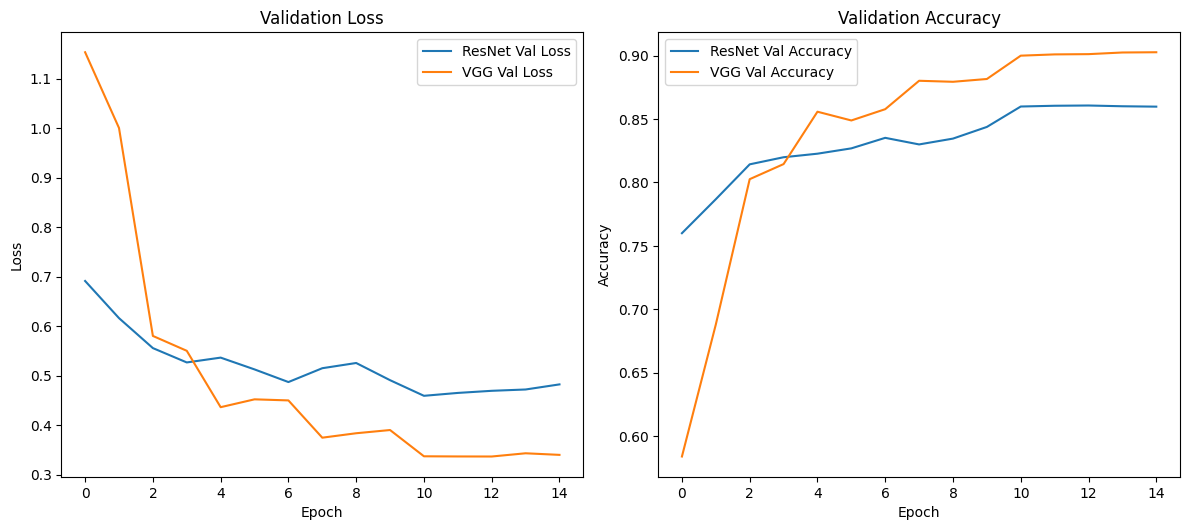

In [ ]:
plt.figure(figsize=(12, 10))
# Plot validation losses
plt.subplot(2, 2, 3)
plt.plot(resnet_val_losses, label='ResNet Val Loss')
plt.plot(vgg_val_losses, label='VGG Val Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracies
plt.subplot(2, 2, 4)
plt.plot(resnet_val_accuracies, label='ResNet Val Accuracy')
plt.plot(vgg_val_accuracies, label='VGG Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def ensemble_predict(models, dataloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    all_preds = []

    for model in models:
        model.eval()
        preds = []

        with torch.no_grad():
            for batch_X, _ in dataloader:
                batch_X = batch_X.to(device)
                batch_y_probs = model(batch_X)
                preds.append(batch_y_probs.cpu().numpy())

        all_preds.append(np.concatenate(preds, axis=0))

    avg_preds = np.mean(all_preds, axis=0)
    return avg_preds

In [ ]:
# Load the fine-tuned models
resnet.load_state_dict(torch.load('resnet18_finetuned.pth'))
vgg.load_state_dict(torch.load('vgg16_finetuned.pth'))

# Use your previously trained custom model
custom_model = ComplexCNN(num_classes=10, num_inception_blocks=best_params['num_inception_blocks'],
                          inception_out_channels=best_params['inception_out_channels'],
                          batch_norm=best_params['batch_norm'], dropout_prob=best_params['dropout_prob'])
custom_model.load_state_dict(torch.load('CNNInception2.pth'))

# Move all models to the device
resnet = resnet.to(device)
vgg = vgg.to(device)
custom_model = custom_model.to(device)

# Using ensemble for predictions on test data
ensemble_models = [resnet, vgg, custom_model]
ensemble_preds = ensemble_predict(ensemble_models, test_loader)
ensemble_preds_labels = np.argmax(ensemble_preds, axis=1)

# Calculate accuracy
correct = 0
for i, (_, label) in enumerate(test_loader.dataset):
    if ensemble_preds_labels[i] == label:
        correct += 1

ensemble_accuracy = correct / len(test_loader.dataset)
print(f'Ensemble Test Accuracy: {ensemble_accuracy*100:.2f}%')

Ensemble Test Accuracy: 90.48%


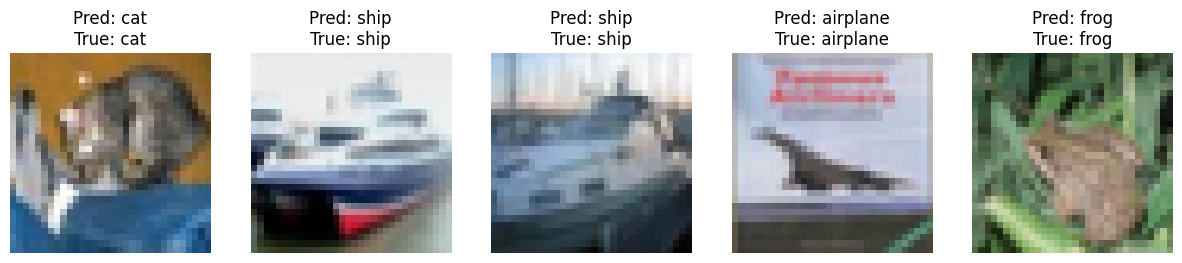

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define a mapping of class indices to text labels
class_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

def show_images_with_predictions(models, dataloader, num_images=5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    ensemble_preds = []
    # Get a batch of images and labels from the dataloader
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images = images.to(device)
    labels = labels.numpy()
    # Get predictions from each model
    for model in models:
        model.eval()
        with torch.no_grad():
            preds = model(images)
            preds = preds.cpu().numpy()
            ensemble_preds.append(preds)

    # Average predictions across models
    avg_preds = np.mean(ensemble_preds, axis=0)
    ensemble_preds_labels = np.argmax(avg_preds, axis=1)
    # Display the first `num_images` images and their predictions
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        image = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert from CHW to HWC
        plt.imshow(image)
        plt.axis('off')
        pred_label = class_labels[ensemble_preds_labels[i]]
        true_label = class_labels[labels[i]]
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}')

    plt.show()

# Assuming you have your models loaded and dataloader defined
show_images_with_predictions(ensemble_models, test_loader, num_images=5)

AutoML

In [ ]:
!pip install autokeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5p

In [ ]:
import numpy as np
from torchvision import datasets

# Load datasets without any transformations
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)

# Function to convert PIL images and labels to NumPy arrays
def dataset_to_numpy(dataset):
    data_list, label_list = [], []
    for img, label in dataset:
        data_list.append(np.array(img))
        label_list.append(label)
    data_np = np.stack(data_list, axis=0)
    label_np = np.array(label_list)
    return data_np, label_np

# Convert datasets to NumPy arrays
train_data, train_labels = dataset_to_numpy(train_dataset)
test_data, test_labels = dataset_to_numpy(test_dataset)

# Normalize data to [0, 1] range
train_data = train_data / 255.0
test_data = test_data / 255.0

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import autokeras as ak

# Define the AutoKeras ImageClassifier
clf = ak.ImageClassifier(max_trials=5, overwrite=True)

# Train the classifier
clf.fit(train_data, train_labels, epochs=5)

# Evaluate the classifier
loss, accuracy = clf.evaluate(test_data, test_labels)
print(f'Test accuracy: {accuracy}')

Trial 3 Complete [02h 14m 08s]
val_loss: 0.08765258640050888

Best val_loss So Far: 0.08765258640050888
Total elapsed time: 02h 48m 55s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
True              |True              |image_block_1/normalize
True              |True              |image_block_1/augment
efficient         |efficient         |image_block_1/block_type
global_avg        |global_avg        |classification_head_1/spatial_reduction_1/reduction_type
0                 |0                 |classification_head_1/dropout
adam              |adam              |optimizer
2e-05             |2e-05             |learning_rate
0.1               |0.1               |image_block_1/image_augmentation_1/translation_factor
True              |True              |image_block_1/image_augmentation_1/horizontal_flip
False             |False             |image_block_1/image_augmentation_1/vertical_flip
0                 |0                 |image_block_1/image_augmentati

In [ ]:
# Predict with the best model
predicted_labels = clf.predict(test_data)

# If you want to get the predicted class labels
predicted_classes = np.argmax(predicted_labels, axis=1)

NameError: name 'clf' is not defined

In [ ]:
# Function to plot images with predictions
def plot_predictions(test_data, test_labels, predicted_classes, class_names, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        ax = plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(test_data[i])
        true_label = class_names[test_labels[i]]
        predicted_label = class_names[predicted_classes[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

# Class names for CIFAR-10
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Plot the results
plot_predictions(test_data, test_labels, predicted_classes, class_names)
plt.show()

NameError: name 'test_data' is not defined

Advesarial

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:18<00:00, 9215909.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Load pretrained inception model
custom_model = ComplexCNN(num_classes=10, num_inception_blocks=best_params['num_inception_blocks'],
                          inception_out_channels=best_params['inception_out_channels'],
                          batch_norm=best_params['batch_norm'], dropout_prob=best_params['dropout_prob'])
custom_model.load_state_dict(torch.load('/content/CNNInception3.pth'))
model = custom_model.to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), lr=0.0001728254534147651, weight_decay=0.007900697294327607)

# FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image.detach()

# Training function
def train(model, train_loader, optimizer, epsilon):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Clean example
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Adversarial example
        data.requires_grad = True # Enable gradient calculation for adversarial examples
        output = model(data)
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        optimizer.zero_grad()
        output = model(perturbed_data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate(model, test_loader, epsilon):
    model.eval()
    clean_correct = 0
    adv_correct = 0
    total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        total += target.size(0)

        # Clean examples
        with torch.no_grad():
            output = model(data)
            _, predicted = output.max(1)
            clean_correct += predicted.eq(target).sum().item()

        # Adversarial examples
        data.requires_grad = True
        output = model(data)
        loss = criterion(output, target)

        # Manually create graph
        grad = torch.autograd.grad(loss, data, create_graph=True)[0]

        perturbed_data = fgsm_attack(data, epsilon, grad)

        with torch.no_grad():
            output = model(perturbed_data)
            _, predicted = output.max(1)
            adv_correct += predicted.eq(target).sum().item()

    clean_acc = 100. * clean_correct / total
    adv_acc = 100. * adv_correct / total
    return clean_acc, adv_acc

In [ ]:
# Training loop
epsilon = 0.01  # FGSM epsilon
epochs = 20

for epoch in range(epochs):
    train(model, train_loader, optimizer, epsilon)
    clean_acc, adv_acc = evaluate(model, test_loader, epsilon)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Clean accuracy: {clean_acc:.2f}%")
    print(f"Adversarial accuracy: {adv_acc:.2f}%")
    print("-----------------------------")

# Final evaluation
clean_acc, adv_acc = evaluate(model, test_loader, epsilon)
print("Final Results:")
print(f"Clean accuracy: {clean_acc:.2f}%")
print(f"Adversarial accuracy: {adv_acc:.2f}%")

Epoch 1/20
Clean accuracy: 74.66%
Adversarial accuracy: 38.42%
-----------------------------
Epoch 2/20
Clean accuracy: 73.58%
Adversarial accuracy: 40.91%
-----------------------------
Epoch 3/20
Clean accuracy: 74.55%
Adversarial accuracy: 42.55%
-----------------------------
Epoch 4/20
Clean accuracy: 72.48%
Adversarial accuracy: 43.56%
-----------------------------
Epoch 5/20
Clean accuracy: 74.04%
Adversarial accuracy: 45.44%
-----------------------------
Epoch 6/20
Clean accuracy: 74.70%
Adversarial accuracy: 46.29%
-----------------------------
Epoch 7/20
Clean accuracy: 74.01%
Adversarial accuracy: 46.96%
-----------------------------
Epoch 8/20
Clean accuracy: 72.35%
Adversarial accuracy: 47.18%
-----------------------------
Epoch 9/20
Clean accuracy: 73.22%
Adversarial accuracy: 46.69%
-----------------------------
Epoch 10/20
Clean accuracy: 73.82%
Adversarial accuracy: 48.23%
-----------------------------
Epoch 11/20
Clean accuracy: 74.28%
Adversarial accuracy: 48.39%
-----

Metrices

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [ ]:
def create_precision_recall_heatmap(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Compute precision and recall for each class
    precision, recall, _, _ = precision_recall_fscore_support(all_targets, all_preds, average=None)

    # Create a DataFrame for the heatmap
    import pandas as pd
    df = pd.DataFrame({'Precision': precision, 'Recall': recall}, index=class_names)

    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap="YlGnBu", fmt='.2f', cbar_kws={'label': 'Score'})
    plt.title('Precision and Recall Heatmap')
    plt.tight_layout()
    plt.show()

    # Print most mislabeled classes
    misclassification_rates = 1 - cm.diagonal() / cm.sum(axis=1)
    top_5_misclassified = np.argsort(misclassification_rates)[-5:][::-1]
    print("Top 5 most mislabeled classes:")
    for idx in top_5_misclassified:
        print(f"{class_names[idx]}: {misclassification_rates[idx]:.2%} misclassification rate")

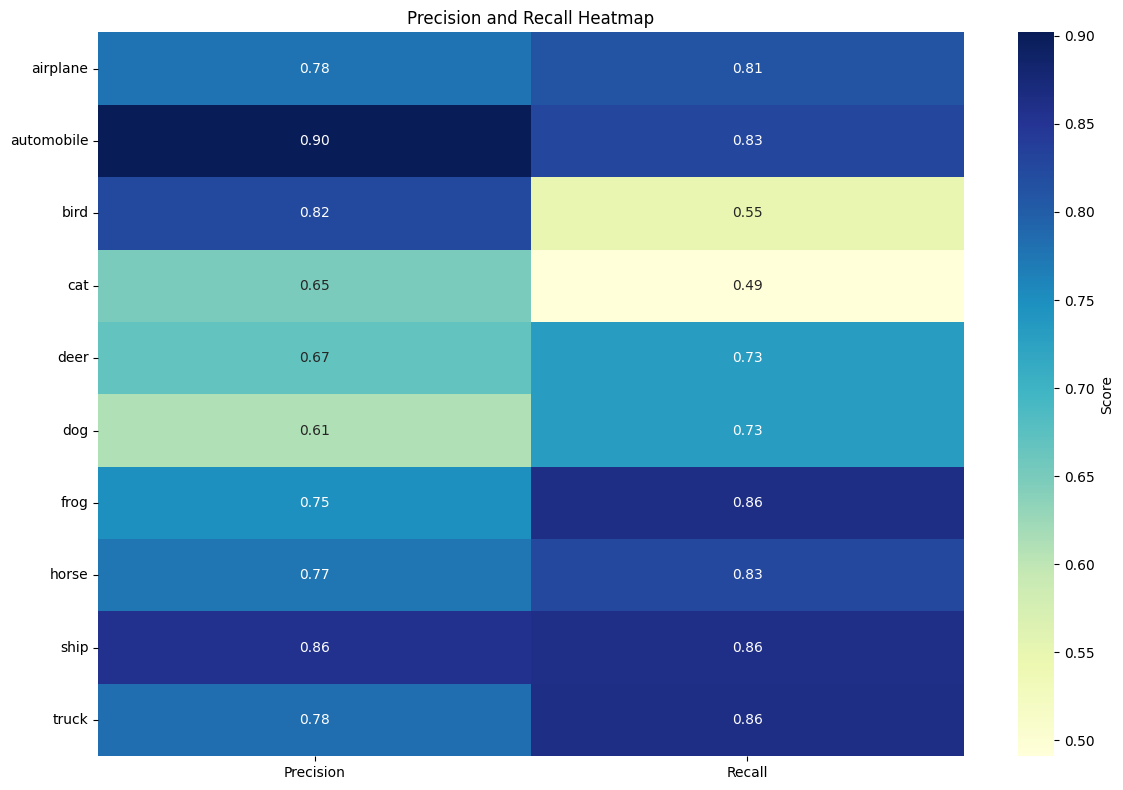

Top 5 most mislabeled classes:
cat: 50.90% misclassification rate
bird: 45.10% misclassification rate
deer: 26.80% misclassification rate
dog: 26.80% misclassification rate
airplane: 18.90% misclassification rate


In [ ]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Call the function
create_precision_recall_heatmap(model, test_loader, class_names)